# STLinear vs. Hop‑Biased STLinear 비교 실험

이 노트북에서는 다음을 수행합니다:
1. 데이터 로드 및 전처리 (첨부된 `baseline_train_refactoring.ipynb` 참고)
2. STLinear (기존 모델)과 STLinear_HopBiased (홉 기반 어텐션 바이어스 모델)를 정의
3. 32가지 하이퍼파라미터 조합을 미리 생성
4. 16개의 랜덤 시드를 고정한 상태로, 각 조합별로 두 모델을 동일한 데이터로 30 에폭 학습
5. 각각의 학습 과정에서 다음 정보를 기록:
   - 각 에폭의 검증 MAPE 기록 (history)
   - MAPE=1과 MAPE=0.5를 달성한 첫 번째 에폭 (달성 못 하면 None)
   - 30 에폭 동안 달성한 최소 MAPE, 최소 Loss
6. 조합별로 두 모델의 검증 MAPE-에폭 그래프를 그려 비교
7. 실험 종료 후, Hop‑Biased 모델이 얼마나 빠르게 MAPE를 낮췄는지, 최종적으로 얼마나 낮은 MAPE를 달성했는지 요약

In [1]:
# 기본
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from collections import defaultdict

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader

# 프로젝트
from dataset.dataset_config import edge_index, edge_attr, week_steps
from dataset.traffic_dataset import TrafficDataset
from utils.Trainer import Trainer
from utils.calculate_performance_index import calculate_performance_index
from models.baselines import GCNMLP, DCRNN, STGCN, MLPBASED, STGAT
from models.STGCN_with_auxiliary_network_model import STGCNWithAux
from models.STLinear import STLinear
from models.STLinear_deriven import STLinear_HopBiased

/usr/local/lib/python3.10/dist-packages/torch_geometric/graphgym/config.py:19: UserWarning: Could not define global config object. Please install 'yacs' via 'pip install yacs' in order to use GraphGym
  warnings.warn("Could not define global config object. Please install "


In [2]:
# reproducibility 확보
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# 하이퍼파라미터 & 데이터셋 준비
BATCH_SIZE = 256
EPOCHS = 50
WINDOW = 12                   # 입력 시퀀스 길이
N_PRED = 3                    # 예측 시퀀스 길이
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

data = np.load('dataset/traffic_dataset_13_smoothen.npy')  # (T_total, E, C) (33600, 50, 3)
# train/valid split (예: 시계열 뒤쪽 20%를 검증으로)

split_idx = int(data.shape[0] * 0.8)
train_data, valid_data = data[:split_idx], data[split_idx:]

def collate_fn(batch):
    xs = torch.stack([item.x for item in batch], dim=0)
    ys = torch.stack([item.y for item in batch], dim=0)
    return xs, ys

train_ds = TrafficDataset(train_data, window=WINDOW, randomize=True)
valid_ds = TrafficDataset(valid_data, window=WINDOW, randomize=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [3]:
# 모델 생성 함수 (하이퍼파라미터를 인자로 받아 초기화)
def make_models(params, distance_hop_tensor):
    """
    params: dict, 하이퍼파라미터 조합 예시
    distance_hop_tensor: torch.LongTensor, shape (E, E)
    반환: (model_base, model_hopbias)
    """
    common_args = {
        'num_nodes': params['num_nodes'],
        'kernel_size': params['kernel_size'],
        'in_steps': params['in_steps'],
        'out_steps': params['out_steps'],
        'input_embedding_dim': params['input_embedding_dim'],
        'tod_embedding_dim': params['tod_embedding_dim'],
        'dow_embedding_dim': params['dow_embedding_dim'],
        'spatial_embedding_dim': params['spatial_embedding_dim'],
        'adaptive_embedding_dim': params['adaptive_embedding_dim'],
        'feed_forward_dim': params['feed_forward_dim'],
        'num_heads': params['num_heads'],  # base 모델도 num_heads 인자는 있지만, 실제로 사용하지 않을 수 있음
        'num_layers': params['num_layers'],
        'dropout': params['dropout'],
        'use_mixed_proj': True,
    }
    # Base STLinear 모델
    model_base = STLinear(**common_args).to(DEVICE)
    # Hop‑Biased 모델
    common_args_hop = common_args.copy()
    common_args_hop['num_heads'] = params['num_heads']  # d_model % num_heads == 0인지 확인 필요
    # distance_hop_tensor은 미리 준비된 (E,E) LongTensor
    model_hop = STLinear_HopBiased(
        **common_args_hop
    ).to(DEVICE)
    return model_base, model_hop


In [4]:
# 3. 하이퍼파라미터 조합 생성 (32가지)
from itertools import product

# 후보 값 정의
param_space = {
    'num_nodes': [50],
    'in_steps': [12],
    'out_steps': [3],
    'kernel_size': [11, 13, 15, 17],
    'input_embedding_dim': [32, 64],
    'tod_embedding_dim': [32, 64],
    'dow_embedding_dim': [32, 64],
    'spatial_embedding_dim': [0, 32],
    'adaptive_embedding_dim': [0, 32],
    'feed_forward_dim': [64, 128],
    'num_heads': [4, 8],           # d_model = input_emb+tod+dow+... = e.g.32+32+32 =96 → 96 % heads ==0? 확인 필요
    'num_layers': [1, 2],
    'dropout': [0.1, 0.2],
}

# 가능한 모든 조합
all_combinations = list(product(*param_space.values()))

# 딕셔너리 목록으로 변환
keys = list(param_space.keys())
param_dicts = [dict(zip(keys, comb)) for comb in all_combinations]

# 32개만 랜덤으로 추출 (혹은 앞 32개)
random.seed(42)
selected_params = random.sample(param_dicts, 32)

print(f"총 조합 수: {len(all_combinations)}, 선택된 실험 조합 수: {len(selected_params)}")

총 조합 수: 2048, 선택된 실험 조합 수: 32


Seed=0, 조합 인덱스=0


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.0597, Valid Loss=1.9621, Train MAPE=1.9488, Valid MAPE=1.6068


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.6679, Valid Loss=1.6444, Train MAPE=1.6492, Valid MAPE=1.2426


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.5267, Valid Loss=1.4905, Train MAPE=1.5406, Valid MAPE=1.0769


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.4243, Valid Loss=1.3814, Train MAPE=1.4702, Valid MAPE=0.9753


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.3464, Valid Loss=1.2996, Train MAPE=1.3824, Valid MAPE=0.8741


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.2758, Valid Loss=1.2274, Train MAPE=1.3171, Valid MAPE=0.8173


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.9848, Valid Loss=1.8840, Train MAPE=1.9530, Valid MAPE=1.6391


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.5236, Valid Loss=1.4910, Train MAPE=1.6624, Valid MAPE=1.2403


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.3527, Valid Loss=1.3094, Train MAPE=1.5339, Valid MAPE=1.0182


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.2424, Valid Loss=1.1920, Train MAPE=1.4611, Valid MAPE=0.8786


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1617, Valid Loss=1.1104, Train MAPE=1.3621, Valid MAPE=0.7964


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.1051, Valid Loss=1.0587, Train MAPE=1.2932, Valid MAPE=0.7283


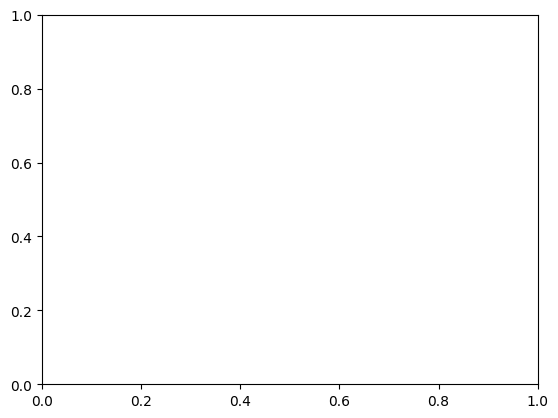

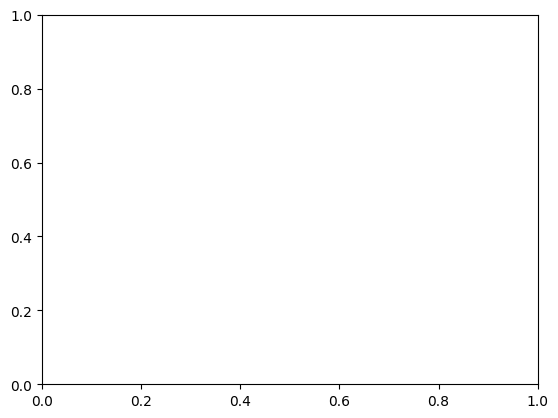

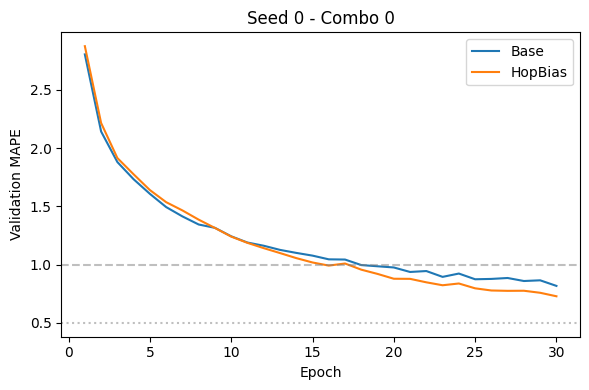

Seed=0, 조합 인덱스=1


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.0758, Valid Loss=1.9870, Train MAPE=1.8964, Valid MAPE=1.5390


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.5751, Valid Loss=1.5286, Train MAPE=1.6689, Valid MAPE=1.2931


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.3634, Valid Loss=1.3143, Train MAPE=1.5174, Valid MAPE=1.0332


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.2405, Valid Loss=1.1902, Train MAPE=1.4065, Valid MAPE=0.9024


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1556, Valid Loss=1.1082, Train MAPE=1.2828, Valid MAPE=0.8038


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0952, Valid Loss=1.0518, Train MAPE=1.2018, Valid MAPE=0.7522


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.1387, Valid Loss=2.0558, Train MAPE=1.9625, Valid MAPE=1.5590


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.6718, Valid Loss=1.6172, Train MAPE=1.6762, Valid MAPE=1.2259


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.4735, Valid Loss=1.4219, Train MAPE=1.5389, Valid MAPE=1.0291


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.3375, Valid Loss=1.2783, Train MAPE=1.4429, Valid MAPE=0.9446


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.2021, Valid Loss=1.1428, Train MAPE=1.3410, Valid MAPE=0.8479


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.1142, Valid Loss=1.0610, Train MAPE=1.2373, Valid MAPE=0.7649


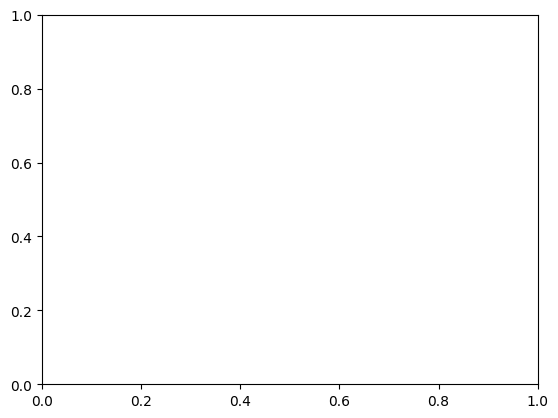

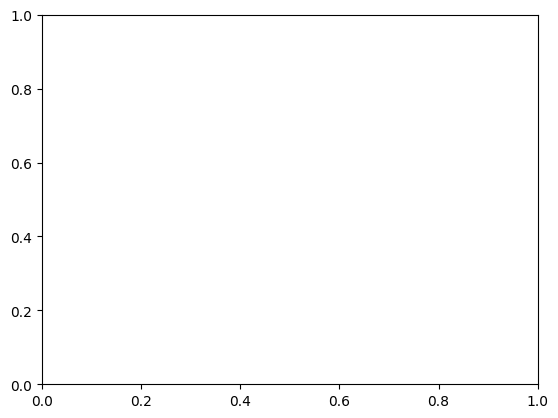

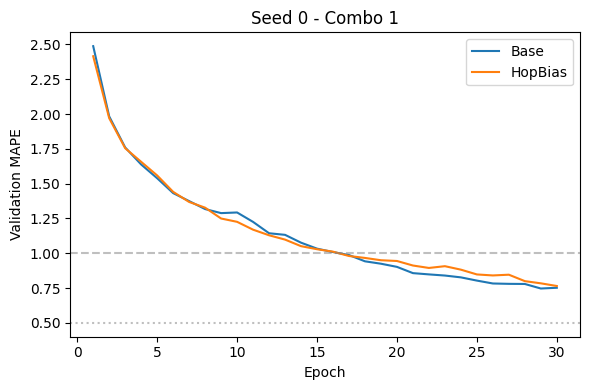

Seed=0, 조합 인덱스=2


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.0847, Valid Loss=1.9957, Train MAPE=1.9552, Valid MAPE=1.5970


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.5787, Valid Loss=1.5274, Train MAPE=1.7067, Valid MAPE=1.3042


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.3545, Valid Loss=1.3037, Train MAPE=1.5497, Valid MAPE=1.0466


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.2288, Valid Loss=1.1765, Train MAPE=1.4321, Valid MAPE=0.9167


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1395, Valid Loss=1.0902, Train MAPE=1.3067, Valid MAPE=0.8122


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0794, Valid Loss=1.0337, Train MAPE=1.2196, Valid MAPE=0.7502


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.1410, Valid Loss=2.0591, Train MAPE=1.9766, Valid MAPE=1.5729


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.6717, Valid Loss=1.6138, Train MAPE=1.6828, Valid MAPE=1.2266


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.4640, Valid Loss=1.4111, Train MAPE=1.5455, Valid MAPE=1.0313


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.3283, Valid Loss=1.2688, Train MAPE=1.4505, Valid MAPE=0.9513


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.2031, Valid Loss=1.1420, Train MAPE=1.3544, Valid MAPE=0.8521


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.1127, Valid Loss=1.0565, Train MAPE=1.2572, Valid MAPE=0.7877


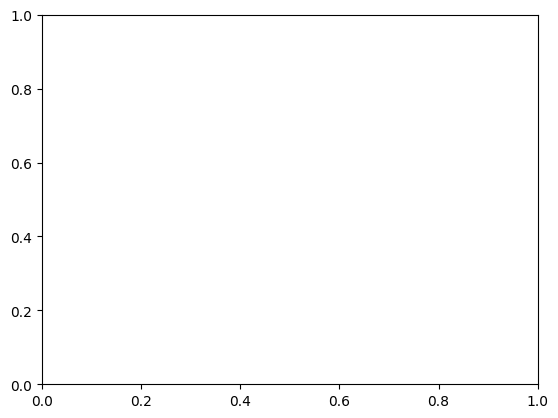

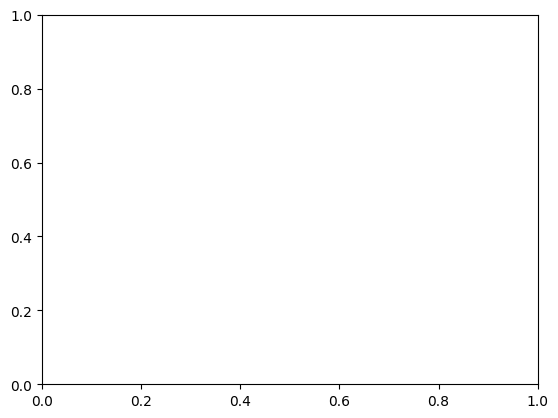

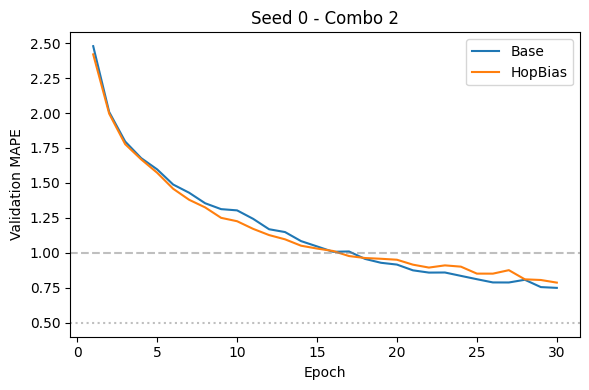

Seed=0, 조합 인덱스=3


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.9571, Valid Loss=1.8086, Train MAPE=2.2057, Valid MAPE=1.4696


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.4184, Valid Loss=1.3583, Train MAPE=1.8876, Valid MAPE=1.1052


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.2533, Valid Loss=1.1848, Train MAPE=1.7109, Valid MAPE=0.9328


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.1445, Valid Loss=1.0751, Train MAPE=1.5912, Valid MAPE=0.8442


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.0751, Valid Loss=1.0085, Train MAPE=1.4486, Valid MAPE=0.7043


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0258, Valid Loss=0.9708, Train MAPE=1.3433, Valid MAPE=0.6573


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.8431, Valid Loss=1.7001, Train MAPE=2.1001, Valid MAPE=1.4870


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.4303, Valid Loss=1.3858, Train MAPE=1.8454, Valid MAPE=1.1356


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.2749, Valid Loss=1.2126, Train MAPE=1.6986, Valid MAPE=0.9596


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.1696, Valid Loss=1.1039, Train MAPE=1.5909, Valid MAPE=0.8189


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.0990, Valid Loss=1.0438, Train MAPE=1.4515, Valid MAPE=0.7369


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0529, Valid Loss=0.9971, Train MAPE=1.3538, Valid MAPE=0.6709


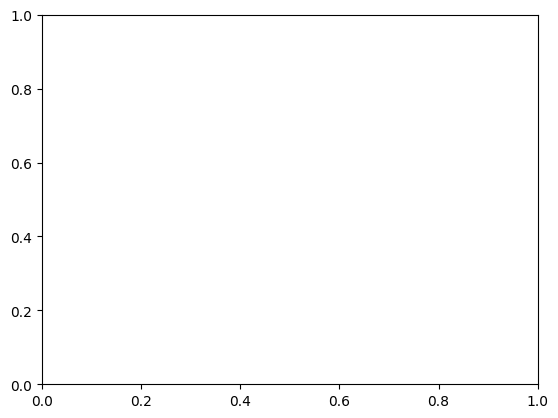

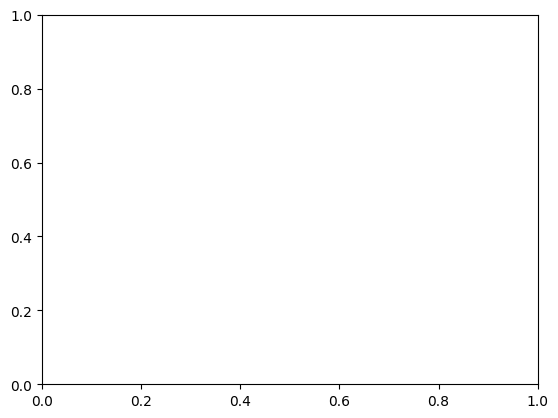

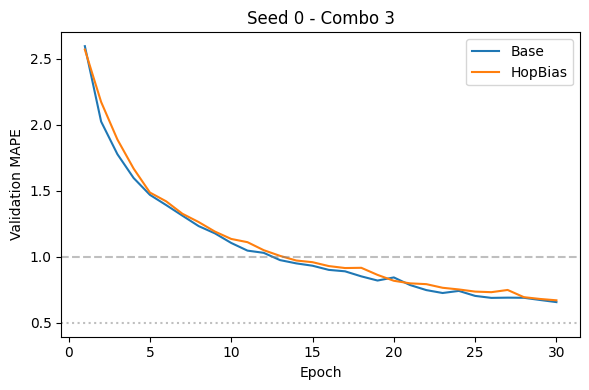

Seed=0, 조합 인덱스=4


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.9847, Valid Loss=1.8754, Train MAPE=1.9500, Valid MAPE=1.5157


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.5393, Valid Loss=1.5063, Train MAPE=1.6759, Valid MAPE=1.2090


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.3582, Valid Loss=1.3050, Train MAPE=1.5766, Valid MAPE=1.0640


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.2136, Valid Loss=1.1628, Train MAPE=1.4403, Valid MAPE=0.8990


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1240, Valid Loss=1.0749, Train MAPE=1.3155, Valid MAPE=0.7999


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0642, Valid Loss=1.0169, Train MAPE=1.2154, Valid MAPE=0.7072


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.0063, Valid Loss=1.9033, Train MAPE=1.9939, Valid MAPE=1.5969


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.5079, Valid Loss=1.4675, Train MAPE=1.6582, Valid MAPE=1.1930


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.3348, Valid Loss=1.2858, Train MAPE=1.5057, Valid MAPE=0.9762


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.2168, Valid Loss=1.1652, Train MAPE=1.4024, Valid MAPE=0.8555


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1346, Valid Loss=1.0848, Train MAPE=1.2860, Valid MAPE=0.7668


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0771, Valid Loss=1.0327, Train MAPE=1.2059, Valid MAPE=0.7121


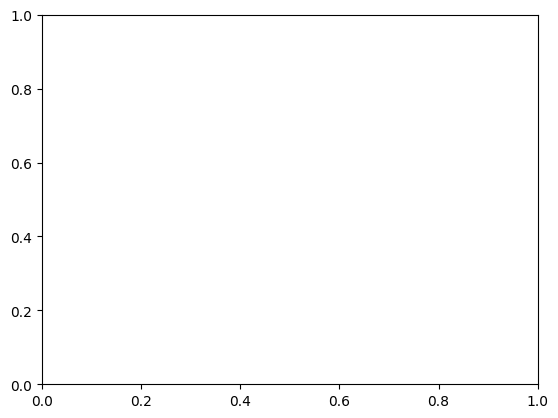

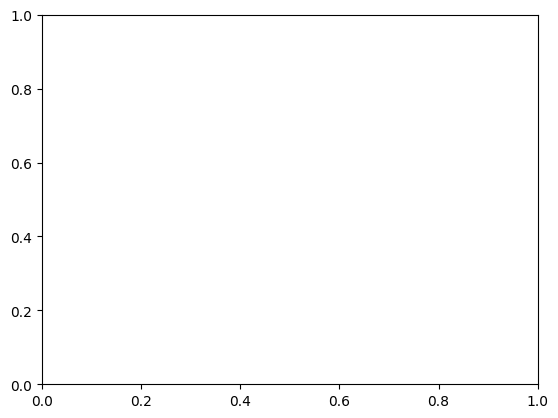

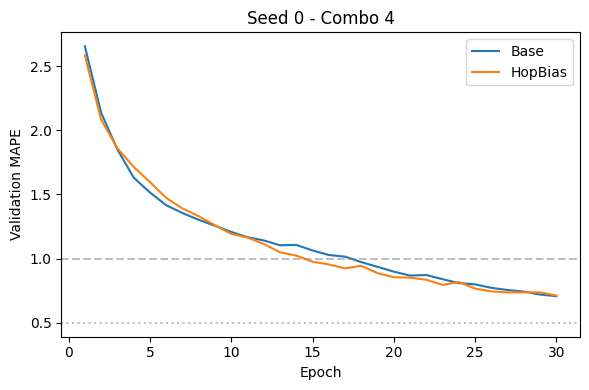

Seed=0, 조합 인덱스=5


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.1109, Valid Loss=1.9982, Train MAPE=2.2860, Valid MAPE=1.6128


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.5707, Valid Loss=1.4977, Train MAPE=1.9833, Valid MAPE=1.2738


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.3567, Valid Loss=1.2841, Train MAPE=1.7556, Valid MAPE=0.9883


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.2423, Valid Loss=1.1687, Train MAPE=1.6191, Valid MAPE=0.8725


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1552, Valid Loss=1.0780, Train MAPE=1.4756, Valid MAPE=0.7560


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0848, Valid Loss=1.0145, Train MAPE=1.3704, Valid MAPE=0.6856


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.1661, Valid Loss=2.0658, Train MAPE=2.4534, Valid MAPE=1.8263


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.6696, Valid Loss=1.5875, Train MAPE=2.0907, Valid MAPE=1.3933


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.4321, Valid Loss=1.3553, Train MAPE=1.9066, Valid MAPE=1.1060


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.2847, Valid Loss=1.2027, Train MAPE=1.7399, Valid MAPE=0.9240


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1729, Valid Loss=1.0920, Train MAPE=1.5731, Valid MAPE=0.8193


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0987, Valid Loss=1.0272, Train MAPE=1.4480, Valid MAPE=0.7391


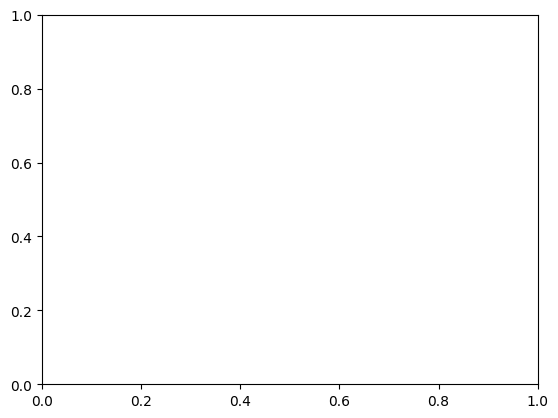

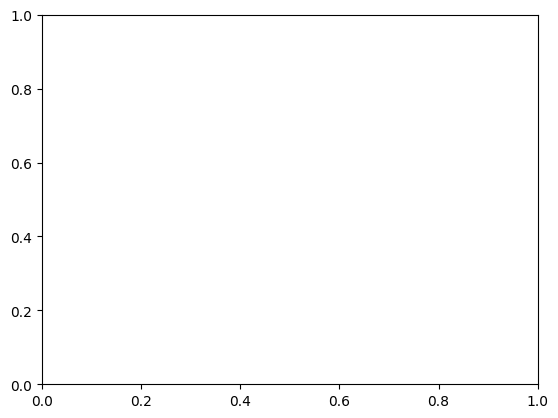

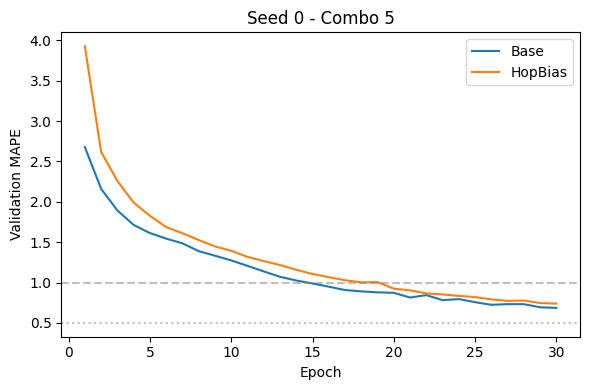

Seed=0, 조합 인덱스=6


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.9490, Valid Loss=1.8165, Train MAPE=2.1934, Valid MAPE=1.4943


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.5046, Valid Loss=1.4482, Train MAPE=1.9109, Valid MAPE=1.1271


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.3492, Valid Loss=1.2808, Train MAPE=1.7414, Valid MAPE=0.9370


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.2291, Valid Loss=1.1529, Train MAPE=1.6128, Valid MAPE=0.8260


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1435, Valid Loss=1.0740, Train MAPE=1.4710, Valid MAPE=0.7810


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0845, Valid Loss=1.0234, Train MAPE=1.3649, Valid MAPE=0.7172


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.0236, Valid Loss=1.9025, Train MAPE=2.2739, Valid MAPE=1.6350


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.5398, Valid Loss=1.4817, Train MAPE=1.9228, Valid MAPE=1.1735


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.3732, Valid Loss=1.3075, Train MAPE=1.7280, Valid MAPE=0.9412


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.2629, Valid Loss=1.1912, Train MAPE=1.6173, Valid MAPE=0.8093


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1813, Valid Loss=1.1091, Train MAPE=1.4838, Valid MAPE=0.7507


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.1237, Valid Loss=1.0601, Train MAPE=1.3874, Valid MAPE=0.7135


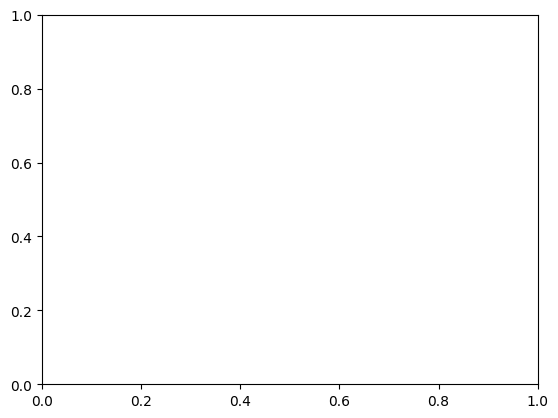

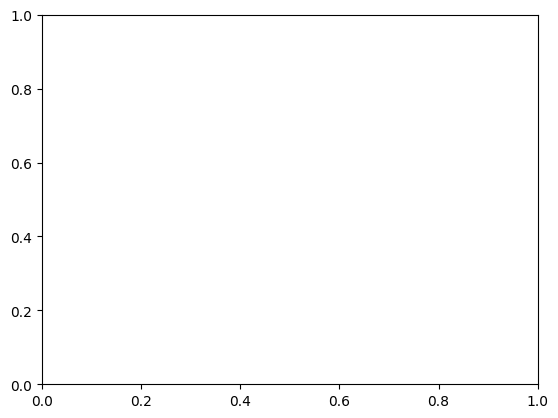

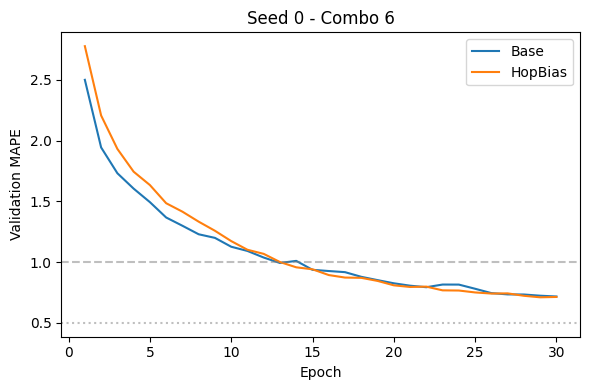

Seed=0, 조합 인덱스=7


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.0613, Valid Loss=1.9645, Train MAPE=1.9261, Valid MAPE=1.5842


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.5876, Valid Loss=1.5520, Train MAPE=1.6591, Valid MAPE=1.2379


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.4011, Valid Loss=1.3562, Train MAPE=1.5249, Valid MAPE=1.0332


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.2746, Valid Loss=1.2269, Train MAPE=1.4517, Valid MAPE=0.9318


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1828, Valid Loss=1.1329, Train MAPE=1.3523, Valid MAPE=0.8027


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.1160, Valid Loss=1.0671, Train MAPE=1.2865, Valid MAPE=0.7627


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.9652, Valid Loss=1.8551, Train MAPE=1.8530, Valid MAPE=1.4787


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.5066, Valid Loss=1.4777, Train MAPE=1.6015, Valid MAPE=1.1774


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.3489, Valid Loss=1.3055, Train MAPE=1.5175, Valid MAPE=1.0023


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.2374, Valid Loss=1.1845, Train MAPE=1.4388, Valid MAPE=0.8852


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1538, Valid Loss=1.1023, Train MAPE=1.3392, Valid MAPE=0.7912


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0946, Valid Loss=1.0440, Train MAPE=1.2719, Valid MAPE=0.7246


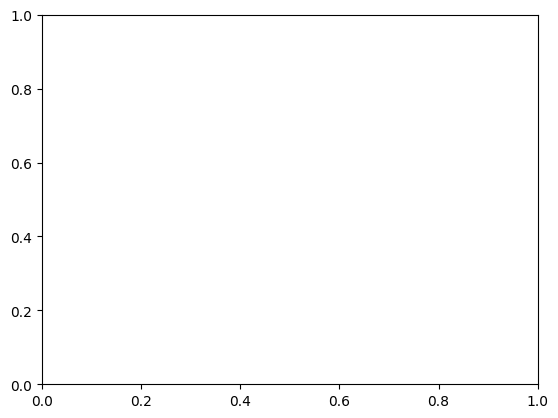

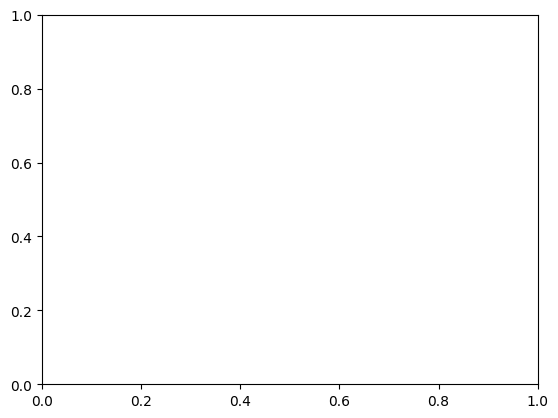

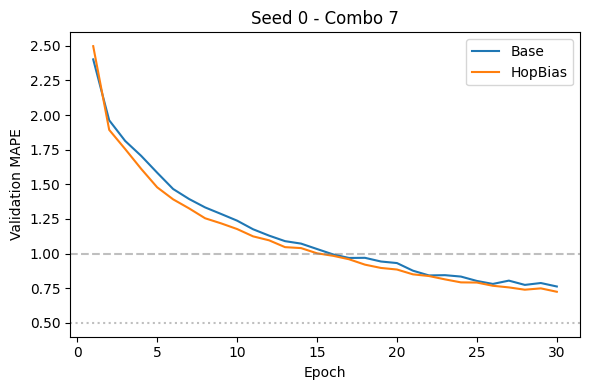

Seed=0, 조합 인덱스=8


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.2066, Valid Loss=2.1295, Train MAPE=2.1706, Valid MAPE=1.8970


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.7960, Valid Loss=1.7529, Train MAPE=1.7787, Valid MAPE=1.4567


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.5881, Valid Loss=1.5480, Train MAPE=1.6176, Valid MAPE=1.1777


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.4843, Valid Loss=1.4413, Train MAPE=1.5189, Valid MAPE=1.0369


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.4066, Valid Loss=1.3583, Train MAPE=1.4159, Valid MAPE=0.9364


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.3333, Valid Loss=1.2828, Train MAPE=1.3448, Valid MAPE=0.8740


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.1313, Valid Loss=2.0450, Train MAPE=1.9646, Valid MAPE=1.7189


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.7072, Valid Loss=1.6739, Train MAPE=1.6672, Valid MAPE=1.3472


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.5342, Valid Loss=1.4946, Train MAPE=1.5672, Valid MAPE=1.1646


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.4270, Valid Loss=1.3825, Train MAPE=1.4988, Valid MAPE=1.0535


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.3353, Valid Loss=1.2879, Train MAPE=1.4039, Valid MAPE=0.9704


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.2427, Valid Loss=1.1891, Train MAPE=1.3299, Valid MAPE=0.8895


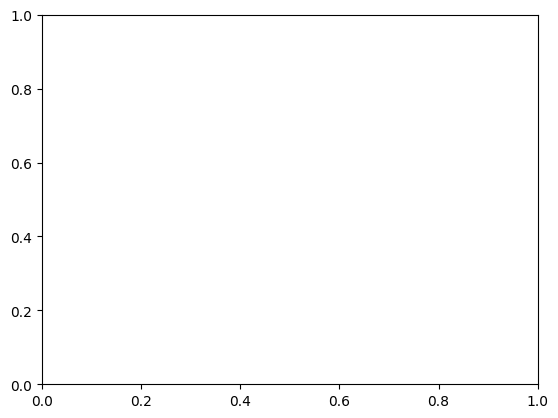

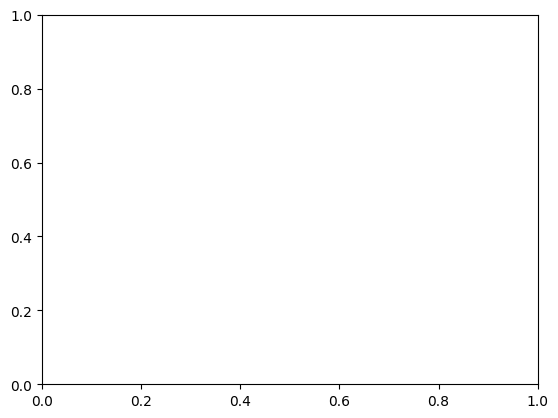

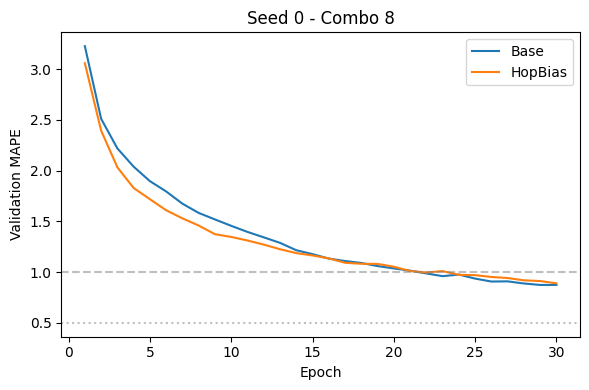

Seed=0, 조합 인덱스=9


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.1997, Valid Loss=2.1059, Train MAPE=2.1181, Valid MAPE=1.7849


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.7638, Valid Loss=1.7071, Train MAPE=1.6935, Valid MAPE=1.3475


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.4741, Valid Loss=1.4243, Train MAPE=1.5482, Valid MAPE=1.1387


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.3409, Valid Loss=1.2883, Train MAPE=1.4536, Valid MAPE=0.9763


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.2457, Valid Loss=1.1904, Train MAPE=1.3353, Valid MAPE=0.8775


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.1712, Valid Loss=1.1170, Train MAPE=1.2606, Valid MAPE=0.7938


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.1472, Valid Loss=2.0641, Train MAPE=2.1284, Valid MAPE=1.8014


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.7374, Valid Loss=1.6855, Train MAPE=1.6724, Valid MAPE=1.3111


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.5120, Valid Loss=1.4662, Train MAPE=1.5292, Valid MAPE=1.0828


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.3755, Valid Loss=1.3225, Train MAPE=1.4702, Valid MAPE=1.0019


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.2523, Valid Loss=1.1993, Train MAPE=1.3612, Valid MAPE=0.8950


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.1708, Valid Loss=1.1195, Train MAPE=1.2686, Valid MAPE=0.8067


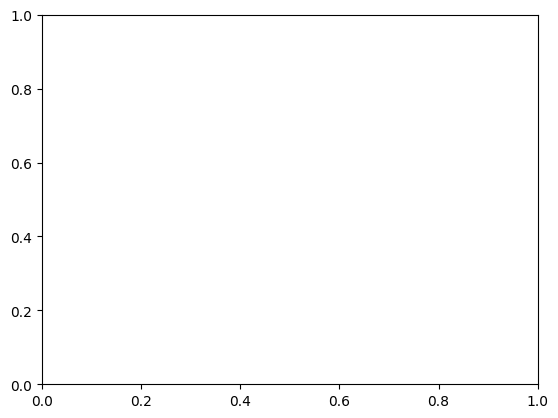

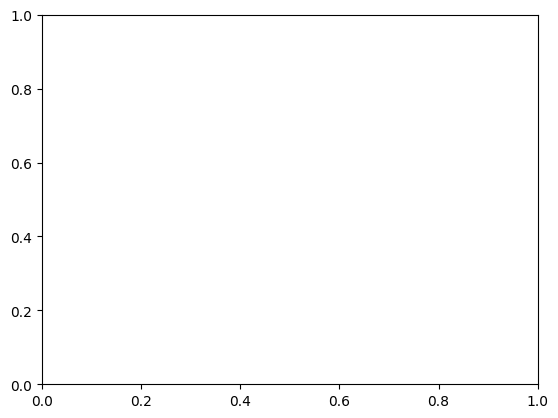

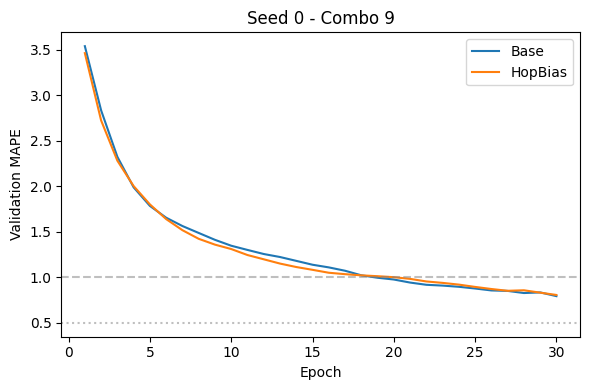

Seed=0, 조합 인덱스=10


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.0127, Valid Loss=1.9149, Train MAPE=1.8685, Valid MAPE=1.4261


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.4983, Valid Loss=1.4587, Train MAPE=1.5908, Valid MAPE=1.1219


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.3245, Valid Loss=1.2803, Train MAPE=1.4734, Valid MAPE=0.9697


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.2122, Valid Loss=1.1642, Train MAPE=1.3894, Valid MAPE=0.8442


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1339, Valid Loss=1.0873, Train MAPE=1.2649, Valid MAPE=0.7661


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0738, Valid Loss=1.0318, Train MAPE=1.1826, Valid MAPE=0.7066


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.0344, Valid Loss=1.9317, Train MAPE=1.9261, Valid MAPE=1.5149


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.4703, Valid Loss=1.4392, Train MAPE=1.5756, Valid MAPE=1.1401


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.3061, Valid Loss=1.2603, Train MAPE=1.4156, Valid MAPE=0.9028


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.1865, Valid Loss=1.1370, Train MAPE=1.3304, Valid MAPE=0.8087


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1025, Valid Loss=1.0541, Train MAPE=1.2176, Valid MAPE=0.7158


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0417, Valid Loss=1.0001, Train MAPE=1.1341, Valid MAPE=0.7039


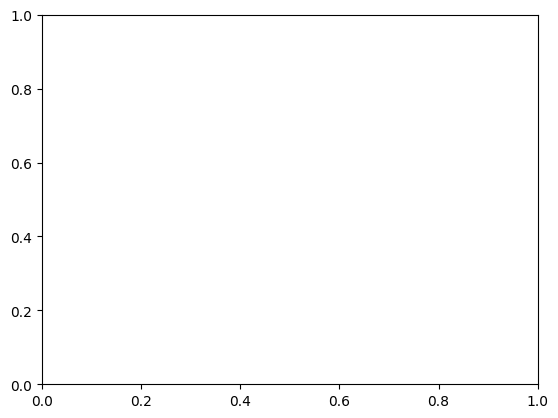

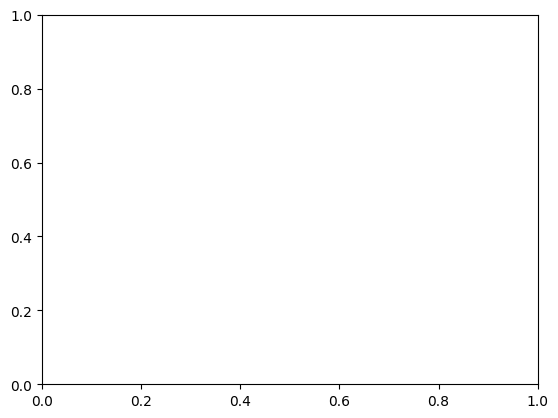

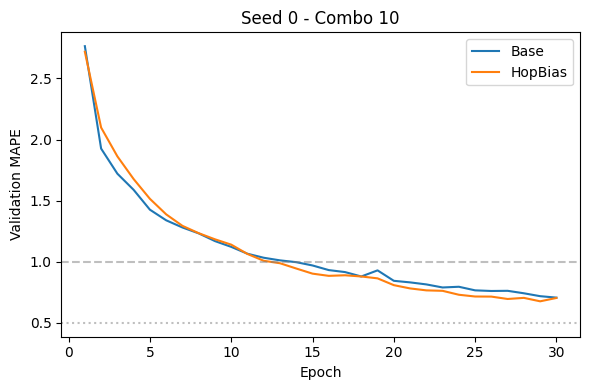

Seed=0, 조합 인덱스=11


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.9284, Valid Loss=1.7763, Train MAPE=2.2979, Valid MAPE=1.6005


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.4473, Valid Loss=1.3913, Train MAPE=2.0394, Valid MAPE=1.2564


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.2878, Valid Loss=1.2125, Train MAPE=1.8420, Valid MAPE=0.9782


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.1707, Valid Loss=1.0938, Train MAPE=1.7092, Valid MAPE=0.8456


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.0883, Valid Loss=1.0177, Train MAPE=1.5505, Valid MAPE=0.7442


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0347, Valid Loss=0.9707, Train MAPE=1.4273, Valid MAPE=0.6998


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.8516, Valid Loss=1.7077, Train MAPE=2.0721, Valid MAPE=1.3774


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.4620, Valid Loss=1.4096, Train MAPE=1.8697, Valid MAPE=1.0530


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.3064, Valid Loss=1.2420, Train MAPE=1.7139, Valid MAPE=0.9199


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.1927, Valid Loss=1.1225, Train MAPE=1.5747, Valid MAPE=0.7980


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1047, Valid Loss=1.0404, Train MAPE=1.4237, Valid MAPE=0.7097


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0433, Valid Loss=0.9836, Train MAPE=1.3198, Valid MAPE=0.6521


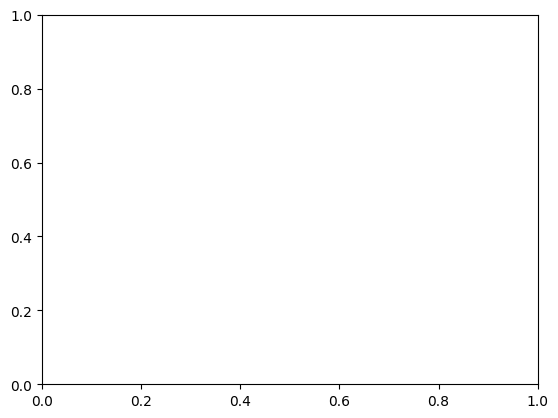

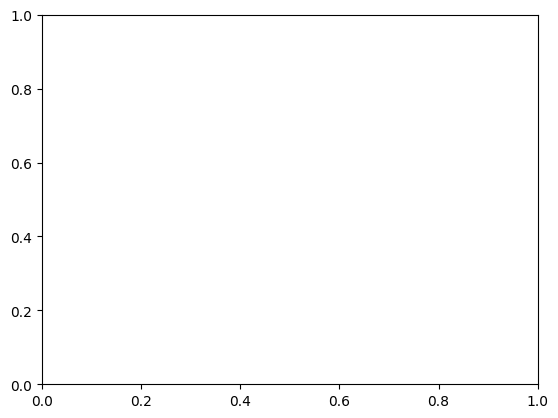

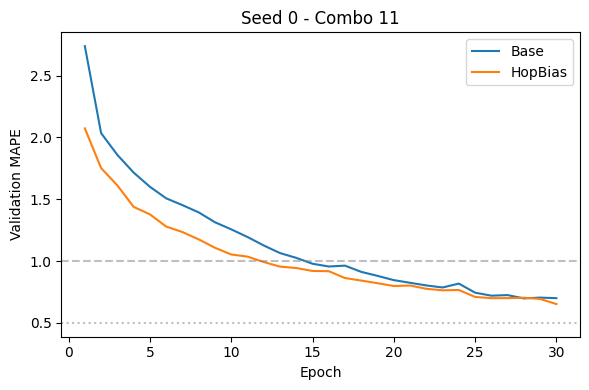

Seed=0, 조합 인덱스=12


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.9741, Valid Loss=1.8276, Train MAPE=2.3156, Valid MAPE=1.6080


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.4606, Valid Loss=1.4029, Train MAPE=2.0126, Valid MAPE=1.2213


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.2898, Valid Loss=1.2153, Train MAPE=1.7951, Valid MAPE=0.9463


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.1683, Valid Loss=1.0935, Train MAPE=1.6686, Valid MAPE=0.8269


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.0868, Valid Loss=1.0171, Train MAPE=1.5188, Valid MAPE=0.7253


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0345, Valid Loss=0.9725, Train MAPE=1.4080, Valid MAPE=0.6861


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.8701, Valid Loss=1.7316, Train MAPE=2.0710, Valid MAPE=1.3687


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.4920, Valid Loss=1.4430, Train MAPE=1.8526, Valid MAPE=1.0420


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.3436, Valid Loss=1.2800, Train MAPE=1.6980, Valid MAPE=0.9296


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.2179, Valid Loss=1.1474, Train MAPE=1.5661, Valid MAPE=0.8535


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1250, Valid Loss=1.0602, Train MAPE=1.4216, Valid MAPE=0.7300


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0620, Valid Loss=1.0049, Train MAPE=1.3162, Valid MAPE=0.6811


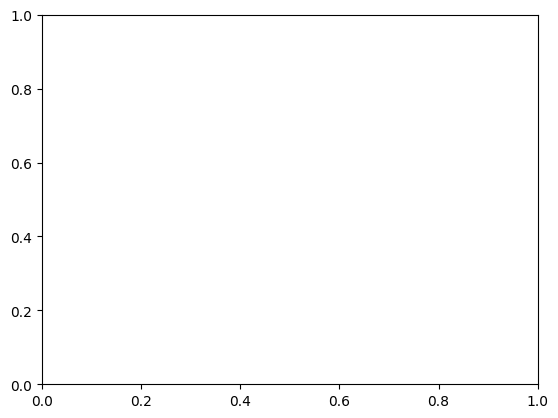

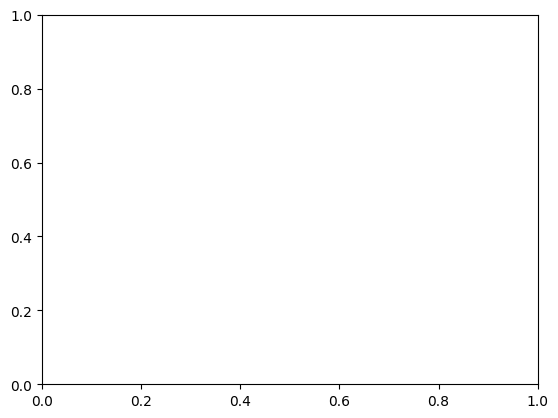

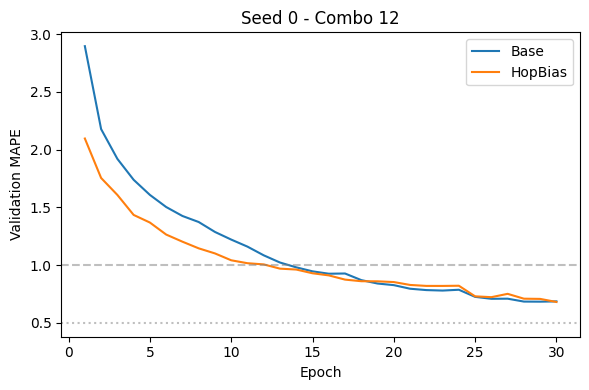

Seed=0, 조합 인덱스=13


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=1.9459, Valid Loss=1.8560, Train MAPE=1.9585, Valid MAPE=1.6650


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.5558, Valid Loss=1.5306, Train MAPE=1.6382, Valid MAPE=1.2705


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.3965, Valid Loss=1.3564, Train MAPE=1.5179, Valid MAPE=1.0732


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.2826, Valid Loss=1.2406, Train MAPE=1.4379, Valid MAPE=0.9568


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1981, Valid Loss=1.1560, Train MAPE=1.3430, Valid MAPE=0.8608


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.1300, Valid Loss=1.0900, Train MAPE=1.2651, Valid MAPE=0.7897


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 3/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 4/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 5/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 5] Train Loss=2.0547, Valid Loss=1.9570, Train MAPE=2.0853, Valid MAPE=1.7331


Train 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 6/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 7/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 8/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 9/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 10/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 10] Train Loss=1.4962, Valid Loss=1.4619, Train MAPE=1.6720, Valid MAPE=1.2680


Train 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 11/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 12/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 13/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 14/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 15/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 15] Train Loss=1.3218, Valid Loss=1.2774, Train MAPE=1.5587, Valid MAPE=1.0048


Train 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 16/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 17/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 18/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 19/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 20/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 20] Train Loss=1.2092, Valid Loss=1.1593, Train MAPE=1.4610, Valid MAPE=0.9013


Train 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 21/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 22/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 23/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 24/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 25/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 25] Train Loss=1.1308, Valid Loss=1.0789, Train MAPE=1.3631, Valid MAPE=0.7745


Train 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 26/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 27/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 28/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 29/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 30/30:   0%|          | 0/14 [00:00<?, ?it/s]

[Epoch 30] Train Loss=1.0741, Valid Loss=1.0237, Train MAPE=1.2893, Valid MAPE=0.7192


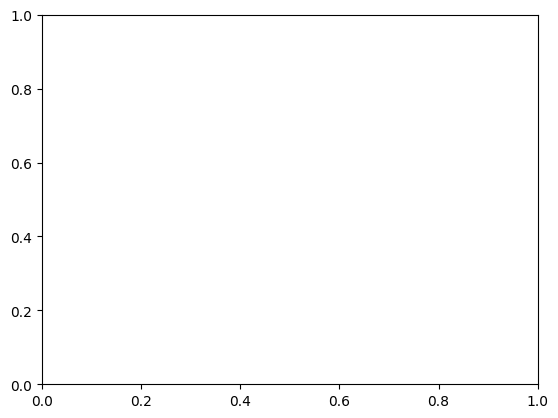

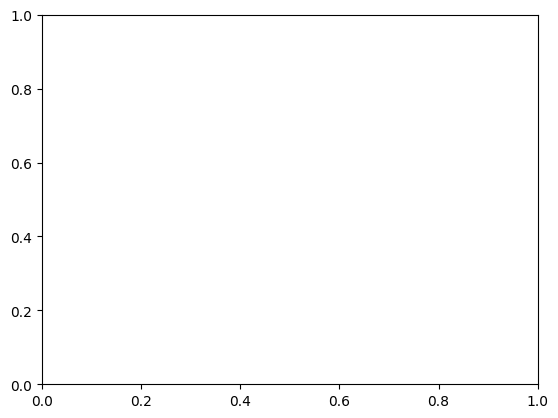

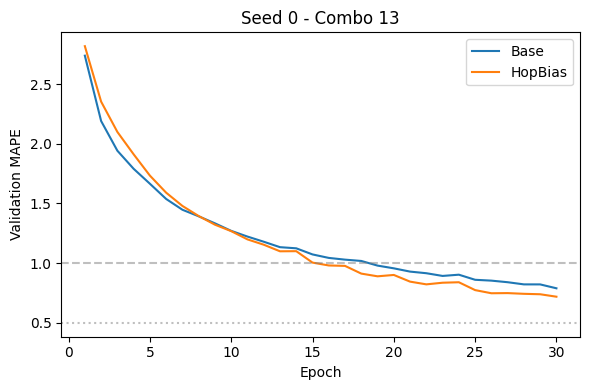

Seed=0, 조합 인덱스=14


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/30:   0%|          | 0/14 [00:00<?, ?it/s]

Train 2/30:   0%|          | 0/14 [00:00<?, ?it/s]

KeyboardInterrupt: 

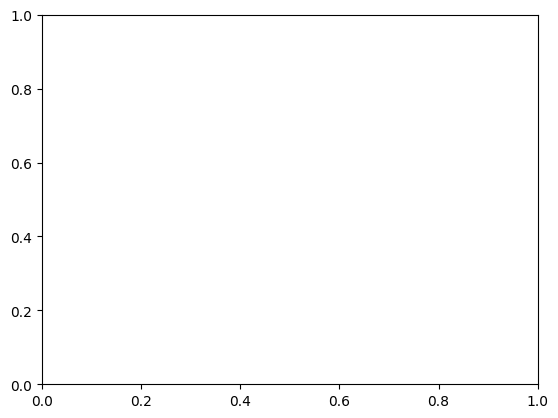

In [5]:
# %% [markdown]
# 4. 반복 실험: 16개의 시드를 사용해 학습 수행
#
# 결과를 기록할 리스트 초기화
results = []
# 시드 목록 (16개)
seeds = list(range(16))

# distance_hop_tensor 준비 (E, E)
# dataset_config.py에서 edge_spd를 가져왔으므로, numpy -> torch.LongTensor로 변환
from dataset.dataset_config import edge_spd
edge_spd_tensor = torch.from_numpy(edge_spd).long().to(DEVICE)

# 학습·평가 함수 정의

def train_and_evaluate(model, train_loader, val_loader, lr, weight_decay, epochs, seed):
    set_seed(seed)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.L1Loss()
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        valid_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=epochs,
        device=DEVICE,
        print_interval=5,
        plot_interval=0
    )
    trainer.fit()
    history = trainer.get_history()
    return history

# 메인 루프
for seed in seeds:
    for idx, params in enumerate(selected_params):
        print(f"Seed={seed}, 조합 인덱스={idx}")
        # 모델 초기화
        model_base, model_hop = make_models(params, edge_spd_tensor)
        # 하이퍼파라미터: 학습률·감쇠 비율 (고정 혹은 params에 포함하면 추가)
        lr = 5e-5
        weight_decay = 1e-5
        epochs = 30
        
        # 4-1) Base 모델 학습
        history_base = train_and_evaluate(model_base, train_loader, valid_loader, lr, weight_decay, epochs, seed)
        # 4-2) Hop‑Biased 모델 학습
        history_hop  = train_and_evaluate(model_hop,  train_loader, valid_loader, lr, weight_decay, epochs, seed)

        # 4-3) 기록: history에서 valid MAPE, valid loss 추출
        val_mape_base = history_base['valid_mape']  # (length=epochs)
        val_loss_base = history_base['valid_loss']  # (length=epochs)
        val_mape_hop  = history_hop['valid_mape']
        val_loss_hop  = history_hop['valid_loss']

        # MAPE=1, 0.5 달성 에폭 찾기
        def first_epoch_leq(arr, threshold):
            for i, v in enumerate(arr):
                if v <= threshold:
                    return i + 1  # 1-based epoch
            return None

        mape1_epoch_base = first_epoch_leq(val_mape_base, 1.0)
        mape05_epoch_base = first_epoch_leq(val_mape_base, 0.5)
        min_mape_base = float(np.min(val_mape_base))
        min_loss_base = float(np.min(val_loss_base))

        mape1_epoch_hop = first_epoch_leq(val_mape_hop, 1.0)
        mape05_epoch_hop = first_epoch_leq(val_mape_hop, 0.5)
        min_mape_hop = float(np.min(val_mape_hop))
        min_loss_hop = float(np.min(val_loss_hop))

        # 4-4) 결과 저장
        results.append({
            'seed': seed,
            'combo_index': idx,
            'params': params,
            'mape1_epoch_base': mape1_epoch_base,
            'mape05_epoch_base': mape05_epoch_base,
            'min_mape_base': min_mape_base,
            'min_loss_base': min_loss_base,
            'mape1_epoch_hop': mape1_epoch_hop,
            'mape05_epoch_hop': mape05_epoch_hop,
            'min_mape_hop': min_mape_hop,
            'min_loss_hop': min_loss_hop,
            'history_base_mape': val_mape_base,
            'history_hop_mape': val_mape_hop,
        })
        
        # 4-5) 동적으로 검증 MAPE-에폭 그래프를 그리기
        # Base 모델 기록된 에폭 수
        epochs_base = len(val_mape_base)  # 예: 30이 아니라 15일 수도 있습니다.

        # HopBias 모델 기록된 에폭 수
        epochs_hop  = len(val_mape_hop)   # 예: 30이 아니라 20일 수도 있습니다.

        plt.figure(figsize=(6, 4))
        # Base 모델은 실제 기록 길이만큼, HopBias 모델도 마찬가지로 그립니다.
        plt.plot(range(1, epochs_base + 1), val_mape_base, label='Base')
        plt.plot(range(1, epochs_hop  + 1), val_mape_hop,  label='HopBias')

        plt.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
        plt.axhline(0.5, color='gray', linestyle=':',  alpha=0.5)
        plt.xlabel('Epoch')
        plt.ylabel('Validation MAPE')
        plt.title(f'Seed {seed} - Combo {idx}')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [7]:
# 5. 실험 결과 분석
df_results = pd.DataFrame(results)

# 예시: combo별로 평균 최저 MAPE 비교 (모델별)
agg_df = df_results.groupby('combo_index').agg({
    'min_mape_base': ['mean', 'std'],
    'min_mape_hop':  ['mean', 'std'],
    'mape1_epoch_base': ['mean', 'std'],
    'mape1_epoch_hop':  ['mean', 'std'],
})
print(agg_df)

            min_mape_base     min_mape_hop     mape1_epoch_base      \
                     mean std         mean std             mean std   
combo_index                                                           
0                0.817259 NaN     0.728294 NaN             18.0 NaN   
1                0.746884 NaN     0.764924 NaN             17.0 NaN   
2                0.750239 NaN     0.787747 NaN             18.0 NaN   
3                0.657282 NaN     0.670912 NaN             13.0 NaN   
4                0.707218 NaN     0.712140 NaN             18.0 NaN   
5                0.685558 NaN     0.739091 NaN             15.0 NaN   
6                0.717225 NaN     0.710693 NaN             13.0 NaN   
7                0.762674 NaN     0.724604 NaN             16.0 NaN   
8                0.873916 NaN     0.889531 NaN             22.0 NaN   
9                0.793809 NaN     0.806657 NaN             19.0 NaN   
10               0.706610 NaN     0.676451 NaN             14.0 NaN   
11    